In [3]:
import os
from multiprocessing import Pool

from Bio import Entrez, SeqIO
from io import StringIO
import numpy as np
import pandas as pd
import re
import paramiko
from getpass import getpass
import traceback
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

/home/stotoshka/Soft/anaconda3/envs/research/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
os.chdir("/home/stotoshka/Documents/ANGEL_dev")

In [3]:
train_invivo = pd.read_csv("Proteasome/in_vivo/train/total_train_invivo.csv",sep=";")
train_invivo.head()

,linear_peptide_seq,sequence
0,LAVHPSGVAL,MGWDLTVKMLAGNEFQVSLSSSMSVSELKAQITQKIGVHAFQQRLA...
1,FAYDGKDYLTL,SHTLQWMHGCELGPDRRFLRGYEQFAYDGKDYLTLNEDLRSWTAVD...
2,RRYLENGKETL,TAPETLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRFITV...
3,RRYLENGKETLQR,TAPETLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRFITV...
4,ILTDITKGV,MVNFTVDQIRAIMDKKANIRNMSVIAHVDHGKSTLTDSLVCKAGII...


In [4]:
def isCorrectSequence(sequence):
    alphabet = list("ACDEFGHIKLMNPQRSTVWY")
    seq = sequence.strip()
    for i in range(0,len(seq)):
        if seq[i] not in alphabet:
            return False
    return True

In [5]:
virus_validation = pd.read_excel("Proteasome/in_vivo/validation/pcps_validation.xlsx")
print(virus_validation.shape)
virus_validation = virus_validation[virus_validation["HLA I restriction"].str.contains("HLA")]
virus_validation = virus_validation[virus_validation["CD8 T cell epitope"].apply(isCorrectSequence)]
virus_validation = virus_validation[virus_validation["ref_sequence"].apply(isCorrectSequence)]
virus_validation = virus_validation[~virus_validation["CD8 T cell epitope"].isin(train_invivo["linear_peptide_seq"])]
virus_validation = virus_validation[~virus_validation["ref_sequence"].isin(train_invivo["sequence"])]
virus_validation.reset_index(drop=True,inplace=True)
print(virus_validation.shape)
virus_validation.head()

(820, 6)
(730, 6)


,CD8 T cell epitope,ACN,Protein,HLA I restriction,id,ref_sequence
0,LIGLNGLSL,P9WL67,hypothetical protein Rv2627c,HLA class I,P9WL67,MASSASDGTHERSAFRLSPPVLSGAMGPFMHTGLYVAQSWRDYLGQ...
1,SAFRLSPPV,P9WL67,hypothetical protein Rv2627c,HLA class I,P9WL67,MASSASDGTHERSAFRLSPPVLSGAMGPFMHTGLYVAQSWRDYLGQ...
2,AAFSSARFL,P0CK17,Accessory protein p30II,HLA class I,P0CK17,MALCCFAFSAPCLHLRSRRSCSSCFLRAKSAAFSSARFLRRAFSSS...
3,LIISPLPRV,P0CK17,Accessory protein p30II,HLA-A2,P0CK17,MALCCFAFSAPCLHLRSRRSCSSCFLRAKSAAFSSARFLRRAFSSS...
4,ALFFIIFNK,Q8IIF0,Circumsporozoite protein-related antigen precu...,HLA class I,Q8IIF0,MKILSVFFLALFFIIFNKESLAEKTNKGTGSGVSSKKKNKKGSGEP...


In [6]:
for i in virus_validation.index:
	seq = virus_validation.loc[i,"ref_sequence"]
	start = virus_validation.loc[i,"ref_sequence"].find(virus_validation.loc[i,"CD8 T cell epitope"])
	end = start + len(virus_validation.loc[i,"CD8 T cell epitope"])
	start_point = max(0,start-10)
	end_point = min(end+10,len(seq))
	print(start_point, len(virus_validation.loc[i,"CD8 T cell epitope"]),end_point)
	virus_validation.loc[i,"val_fragment"] = seq[start_point:end_point]
	virus_validation.loc[i,"true_len"] = len(virus_validation.loc[i,"val_fragment"]) == 20 + len(virus_validation.loc[i,"CD8 T cell epitope"])
virus_validation

253 9 282
2 9 31
20 9 49
145 9 174
0 9 28
60 9 89
243 9 272
252 9 281
136 9 165
58 9 87
180 9 209
82 9 111
299 9 328
91 9 120
273 9 302
26 9 55
238 9 267
196 9 225
51 9 80
292 9 321
318 9 347
83 9 112
2613 9 2642
1823 9 1852
1669 9 1698
525 9 554
2692 9 2721
2273 9 2302
3043 9 3072
1563 9 1592
2987 9 3016
308 9 337
1349 9 1378
2392 9 2421
2123 9 2152
2195 9 2224
1486 9 1515
1936 9 1965
2012 9 2041
2600 9 2629
3231 9 3260
2826 9 2855
39 9 68
1964 9 1993
2021 9 2050
1595 9 1624
2337 9 2366
2057 9 2086
2463 9 2492
3189 9 3218
736 9 765
83 9 112
94 9 123
260 9 289
2719 9 2748
84 9 113
2678 9 2707
85 9 114
802 9 831
3240 9 3269
749 9 778
2451 9 2480
1724 9 1753
2131 9 2160
37 9 66
2455 9 2484
1912 9 1941
2828 9 2857
2211 9 2240
1740 9 1769
1089 9 1118
2811 9 2840
790 9 819
3167 9 3196
2173 9 2202
2793 9 2822
2546 9 2575
1069 9 1098
208 9 237
1062 9 1091
121 9 150
2214 9 2243
166 9 195
712 9 741
274 9 303
2716 9 2745
143 9 172
1840 9 1869
2241 9 2270
1028 9 1057
25 9 54
157 9 186
603 9 632
1

,CD8 T cell epitope,ACN,Protein,HLA I restriction,id,ref_sequence,val_fragment,true_len
0,LIGLNGLSL,P9WL67,hypothetical protein Rv2627c,HLA class I,P9WL67,MASSASDGTHERSAFRLSPPVLSGAMGPFMHTGLYVAQSWRDYLGQ...,SWIRSQEEESLIGLNGLSLGGYIASLVAS,True
1,SAFRLSPPV,P9WL67,hypothetical protein Rv2627c,HLA class I,P9WL67,MASSASDGTHERSAFRLSPPVLSGAMGPFMHTGLYVAQSWRDYLGQ...,SSASDGTHERSAFRLSPPVLSGAMGPFMH,True
2,AAFSSARFL,P0CK17,Accessory protein p30II,HLA class I,P0CK17,MALCCFAFSAPCLHLRSRRSCSSCFLRAKSAAFSSARFLRRAFSSS...,CSSCFLRAKSAAFSSARFLRRAFSSSFLF,True
3,LIISPLPRV,P0CK17,Accessory protein p30II,HLA-A2,P0CK17,MALCCFAFSAPCLHLRSRRSCSSCFLRAKSAAFSSARFLRRAFSSS...,NSPTDTKLTMLIISPLPRVWTESSFRIPS,True
4,ALFFIIFNK,Q8IIF0,Circumsporozoite protein-related antigen precu...,HLA class I,Q8IIF0,MKILSVFFLALFFIIFNKESLAEKTNKGTGSGVSSKKKNKKGSGEP...,MKILSVFFLALFFIIFNKESLAEKTNKG,False
...,...,...,...,...,...,...,...,...
725,MPLETQLAI,Q6ZMA7,protein antigen,HLA-B7,Q6ZMA7,MNIRKFIPSLALMLIFFAFANLVLSDANDKAKKPAGKGSPSTLQTP...,GLSGKDSADKMPLETQLAIEEIKSLSNML,True
726,NPKASLLSL,O42053,Nucleoprotein,HLA-B7,O42053,MALSKVKLNDTLNKDQLLSSSKYTIQRSTGDNIDTPNYDVQKHLNK...,GEAGFYHILNNPKASLLSLTQFPNFSSVV,True
727,QVMLRWGVL,O42053,Nucleoprotein,HLA-B8,O42053,MALSKVKLNDTLNKDQLLSSSKYTIQRSTGDNIDTPNYDVQKHLNK...,GLFMNAYGSGQVMLRWGVLAKSVKNIMLG,True
728,TAKSRVHPL,Q9PZT0,viral protein 2,HLA-B8,Q9PZT0,MSKESGKWWESDDKFAKAVYQQFVEFYEKVTGTDLELIQILKDHYN...,HGYEKPEELWTAKSRVHPL,False


In [7]:
len(virus_validation.loc[0,"ref_sequence"][253:282])
print(virus_validation.loc[0,"ref_sequence"][253:282])
print(virus_validation.loc[0,"CD8 T cell epitope"])

SWIRSQEEESLIGLNGLSLGGYIASLVAS
LIGLNGLSL


In [8]:
virus_validation.true_len.value_counts()

True     691
False     39
Name: true_len, dtype: int64

In [9]:
virus_validation = virus_validation[virus_validation["true_len"]]
virus_validation.shape

(691, 8)

In [10]:
def generateSamples(X, window_radius=2):
    seqs = list(X["sequence"].unique())
    for i in X.index:
        finded_start = X.loc[i, "sequence"].find(X.loc[i, "linear_peptide_seq"])
        X.loc[i, "end"] = finded_start + len(X.loc[i, "linear_peptide_seq"]) - 1  # сайт левее найденной позиции (C-конец)
    result = pd.DataFrame(columns=["peptide", "sequence","full_sequence", "activity"])
    k = 0
    for s in seqs:
        subset = X.query("sequence == @s").reset_index(drop=True)
        possible_start = 0 + window_radius
        possible_end = len(s) - window_radius  # не включая эту позицию [start;end)
        end = list(subset['end'])
        for i in range(possible_start, possible_end):
            peptide = s[(i - window_radius):(i + window_radius + 1)]
            activity = int(i in end)
            result.loc[k] = [peptide, peptide, s, activity]
            k += 1
    print(result.activity.value_counts())
    return result

In [11]:
def generateSamplesOnlyC(X, window_radius = 2):
	result = pd.DataFrame(columns=["peptide","sequence","substrate","activity"])
	k = 0
	for i in X.index:
		np.random.seed(9)
		end = X.loc[i,"sequence"].find(X.loc[i, "linear_peptide_seq"]) + len(X.loc[i, "linear_peptide_seq"])-1
		end = int(end)#сайт левее найденной позиции
		if end+window_radius+1 > len(X.loc[i,"sequence"]):
			continue
		#positive
		peptide = X.loc[i,"sequence"][(end-window_radius):(end+window_radius+1)]
		if len(peptide) == 2 * window_radius + 1:
			result.loc[k] = [peptide, peptide,X.loc[i,"sequence"], 1]
			k += 1
		else:
			continue
		#negative
		possible = list(range(X.loc[i,"sequence"].find(X.loc[i, "linear_peptide_seq"]), end - window_radius))
		random_site = np.random.choice(possible,1)[0]
		peptide = X.loc[i,"sequence"][(random_site-window_radius):(random_site+window_radius+1)]
		if len(peptide) == 2 * window_radius + 1:
			result.loc[k] = [peptide, peptide, X.loc[i,"sequence"],  0]
			k += 1
		else:
			continue
	print(result.activity.value_counts())
	return result

def getSamplesMulti(X,number_threads = 5, w = 2):
	total = len(X.index)
	size_part = total // number_threads
	size_last_part = size_part + (total - size_part * number_threads)
	            # procs - количество ядер
	            # calc - количество операций на ядро
	partitions = []
	            # делим вычисления на количество ядер
	for proc, start in zip(range(number_threads), range(0, total, size_part)):
	    if proc == number_threads - 1:
	        partition = X[start:start + size_last_part]
	    else:
	        partition = X[start:start + size_part]
	    partitions.append(partition)

	with Pool(number_threads) as p:
	    results = p.starmap(generateSamplesOnlyC, zip(partitions, [w]*len(partitions)))
	return pd.concat(results, ignore_index = True)

In [12]:
virus_validation_prep = virus_validation.loc[:,["CD8 T cell epitope", "val_fragment"]]
virus_validation_prep = virus_validation_prep.rename(columns = {"CD8 T cell epitope":"linear_peptide_seq","val_fragment":"sequence"})
virus_validation_prep.to_csv("Proteasome/in_vivo/validation/virus_validation_prep.csv",sep = ";", index = False)

In [13]:
ready_virus_validation = generateSamples(virus_validation_prep,window_radius = 3)

0    15202
1      691
Name: activity, dtype: int64


In [14]:
ready_virus_validation

,peptide,sequence,full_sequence,activity
0,SWIRSQE,SWIRSQE,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
1,WIRSQEE,WIRSQEE,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
2,IRSQEEE,IRSQEEE,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
3,RSQEEES,RSQEEES,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
4,SQEEESL,SQEEESL,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
...,...,...,...,...
15888,LHGVRDG,LHGVRDG,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0
15889,HGVRDGL,HGVRDGL,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0
15890,GVRDGLV,GVRDGLV,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0
15891,VRDGLVR,VRDGLVR,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0


In [16]:
ready_virus_validation["activity"].value_counts()

0    15202
1      691
Name: activity, dtype: int64

In [17]:
ready_train = getSamplesMulti(train_invivo, number_threads=30, w = 3)

1    13213
0    13210
Name: activity, dtype: int64
1    13251
0    13249
Name: activity, dtype: int64
1    13266
0    13265
Name: activity, dtype: int64
1    13257
0    13252
Name: activity, dtype: int64
1    13087
0    13087
Name: activity, dtype: int64
1    13237
0    13235
Name: activity, dtype: int64
1    13231
0    13228
Name: activity, dtype: int64
1    13164
0    13163
Name: activity, dtype: int64
1    13240
0    13239
Name: activity, dtype: int64
1    13202
0    13200
Name: activity, dtype: int64
1    13241
0    13238
Name: activity, dtype: int64
1    13247
0    13245
Name: activity, dtype: int64
1    13230
0    13225
Name: activity, dtype: int64
1    13251
0    13249
Name: activity, dtype: int64
1    13201
0    13199
Name: activity, dtype: int64
1    13269
0    13268
Name: activity, dtype: int64
1    13232
0    13227
Name: activity, dtype: int64
1    13223
0    13221
Name: activity, dtype: int64
1    13241
0    13237
Name: activity, dtype: int64
1    13275
0    13273
Name: act

In [18]:
ready_train["activity"].value_counts()

1    396796
0    396723
Name: activity, dtype: int64

In [19]:
ready_train.to_csv("Proteasome/in_vivo/validation/ready_train_invivo.csv",sep = ";",index = False)

In [20]:
ready_virus_validation.to_csv("Proteasome/in_vivo/validation/ready_validation_invivo.csv",sep = ";",index = False)

In [21]:
%%time
path_to_config = "Proteasome/in_vivo/converter_config.json"
command = f"python tools/generateConfigForConverter.py -i {os.path.join(os.getcwd(),'Proteasome/in_vivo/validation/ready_train_invivo.csv')} -o {os.path.join(os.getcwd(),'Proteasome/in_vivo/sdf')} -c peptide -u -t 10 {path_to_config}"
os.system(command)
print("Convertation")
convert_command = f"python tools/SeqToSDF.py {path_to_config}"
os.system(convert_command)

Success
Convertation
Success
--- 435.88141107559204 seconds ---
CPU times: user 13 ms, sys: 387 µs, total: 13.4 ms
Wall time: 7min 16s


0

In [22]:
%%time
path_to_config = "Proteasome/in_vivo/converter_config.json"
command = f"python tools/generateConfigForConverter.py -i {os.path.join(os.getcwd(),'Proteasome/in_vivo/validation/ready_validation_invivo.csv')} -o {os.path.join(os.getcwd(),'Proteasome/in_vivo/sdf')} -c peptide -u -t 10 {path_to_config}"
os.system(command)
print("Convertation")
convert_command = f"python tools/SeqToSDF.py {path_to_config}"
os.system(convert_command)

Success
Convertation
Success
--- 6.517477750778198 seconds ---
CPU times: user 2.64 ms, sys: 0 ns, total: 2.64 ms
Wall time: 6.89 s


0

In [23]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
rm Proteasome/in_vivo/sdf/*.txt

In [33]:
cancer_validation = pd.read_excel("Proteasome/data/raw/pepsickle_validation_invivo.xlsx",header=1)
cancer_validation.head()

/home/stotoshka/Soft/anaconda3/envs/research/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,Intensity Mel-12_HLA-I (arbitrary units),Intensity Mel-12_HLA-II (arbitrary units),Intensity Mel-15_HLA-I (arbitrary units),Intensity Mel-15_HLA-II (arbitrary units),Intensity Mel-16_HLA-I (arbitrary units),Intensity Mel-16_HLA-II (arbitrary units),Intensity Mel-20_HLA-I (arbitrary units),Intensity Mel-20_HLA-II (arbitrary units),Intensity Mel-21_HLA-I (arbitrary units),Intensity Mel-21_HLA-II (arbitrary units),...,Start position,End position,Sequence,Proteins,Gene Names,Protein Names,id,Peptide ID,Evidence IDs,Phospho (STY) site IDs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,152.0,160.0,AAAAAAAAK,Q9NRF2;P50914;E7ENM0;E7EN65;P15502-5;P15502-2;...,SH2B1;RPL14;ELN;HMX3,SH2B adapter protein 1;60S ribosomal protein L...,0,0,0,NaN
1,NaN,NaN,29.10722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171.0,179.0,AAAAAAAAR,Q504T8;Q9Y651;J9JIF5;P43694;P43694-2;A0A075B73...,MIDN;SOX21;CXXC4;GATA4;EPPK1;ID4,Midnolin;Transcription factor SOX-21;Transcrip...,1,1,1;2;3;4;5;6;7;8;9;10;11;12;13;14,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,17.0,AAAAAAAQSVY,P07203;P07203-2,GPX1,Glutathione peroxidase 1,2,2,15,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,14.0,AAAAAAAVGVR,Q9NRU3;Q9NRU3-2,CNNM1,Metal transporter CNNM1,3,3,16;17,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,403.0,413.0,AAAAAAAVVAY,Q04724;Q5T7A9,TLE1,Transducin-like enhancer protein 1,4,4,18;19,NaN


In [34]:
cancer_validation.shape

(99355, 64)

In [35]:
# pull out class I columns
class_I_columns = []
for i in range(len(cancer_validation.columns)):
    col = cancer_validation.columns[i]
    if "_HLA-I " in col:
        class_I_columns.append(i)

# subset fragments presented on HLA class-I
total_class_I_intensity = cancer_validation[cancer_validation.columns[class_I_columns]].sum(axis=1)
cancer_validation = cancer_validation[total_class_I_intensity > 0]

In [36]:
class_I_columns

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 38,
 40,
 42,
 44,
 45]

In [37]:
cancer_validation.shape

(82411, 64)

In [38]:
cancer_validation = cancer_validation[cancer_validation["Modifications"] == "Unmodified"]
cancer_validation.shape

(77075, 64)

In [27]:
with_ref = pd.read_excel("Proteasome/in_vivo/validation/with_ref_val.xlsx")
with_ref.head()

,Intensity Mel-12_HLA-I (arbitrary units),Intensity Mel-12_HLA-II (arbitrary units),Intensity Mel-15_HLA-I (arbitrary units),Intensity Mel-15_HLA-II (arbitrary units),Intensity Mel-16_HLA-I (arbitrary units),Intensity Mel-16_HLA-II (arbitrary units),Intensity Mel-20_HLA-I (arbitrary units),Intensity Mel-20_HLA-II (arbitrary units),Intensity Mel-21_HLA-I (arbitrary units),Intensity Mel-21_HLA-II (arbitrary units),...,Sequence,Proteins,Gene Names,Protein Names,id_x,Peptide ID,Evidence IDs,Phospho (STY) site IDs,id_y,ref_sequence
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,AAAAAAAVGVR,Q9NRU3;Q9NRU3-2,CNNM1,Metal transporter CNNM1,3,3,16;17,NaN,Q9NRU3;Q9NRU3-2,MAAAAAAAAAVGVRLRDCCSRGAVLLLFFSLSPRPPAAAAWLLGLR...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,AAAAAEALA,P22083,FUT4,"Alpha-(1,3)-fucosyltransferase 4",7,7,49;50,NaN,P22083,MRRLWGAARKPSGAGWEKEWAEAPQEAPGAWSGRLGPGRSGRKGRA...
2,NaN,NaN,31.71313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,AAAARPGPR,Q495Z4,ASB16-AS1,Putative uncharacterized protein ASB16-AS1,33,32,331;332;333;334;335;336;337;338;339;340;341;34...,NaN,Q495Z4,MSGPPSAPQGALAAPRSPAVRRKGLQAPSWGSPGRPAAHSPWACGP...
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,AAAATPAAA,F8WEG7,SF1,NaN,34,33,345;346;347;348,NaN,F8WEG7,MATGANATPLAAAASTATVPRRLVPAAAAAPSAAALPARVAAAAAA...
4,NaN,NaN,28.98066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,AAASTATVPR,F8WEG7,SF1,NaN,124,122,1198;1199;1200;1201;1202;1203;1204;1205;1206;1...,NaN,F8WEG7,MATGANATPLAAAASTATVPRRLVPAAAAAPSAAALPARVAAAAAA...


In [39]:
len(with_ref["Proteins"].unique())

12202

In [ ]:
for i in cancer_validation.index:
	if

In [ ]:
cancer_validation = pd.read_excel("Proteasome/in_vivo/validation/pepsickle_validation.xlsx")
print(virus_validation.shape)
virus_validation = virus_validation[virus_validation["HLA I restriction"].str.contains("HLA")]
virus_validation = virus_validation[virus_validation["CD8 T cell epitope"].apply(isCorrectSequence)]
virus_validation = virus_validation[virus_validation["ref_sequence"].apply(isCorrectSequence)]
virus_validation = virus_validation[~virus_validation["CD8 T cell epitope"].isin(train_invivo["linear_peptide_seq"])]
virus_validation = virus_validation[~virus_validation["ref_sequence"].isin(train_invivo["sequence"])]
virus_validation.reset_index(drop=True,inplace=True)
print(virus_validation.shape)
virus_validation.head()

In [3]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
cp /media/stotoshka/22DC267FDC264D7B/Users/Антон/Desktop/diplom/invivo_val/models/total* Proteasome/in_vivo/results/validation/models/
cp /media/stotoshka/22DC267FDC264D7B/Users/Антон/Desktop/diplom/invivo_val/results/ready_validation* Proteasome/in_vivo/results/validation/results

In [4]:
path = f"Proteasome/in_vivo/results/validation/models/total_invivo_3_9_CRV.LOG"
header = "No	 Check	 Group	 Number	 IAP	 20-Fold	 Activity"
tbl = pd.DataFrame(columns=["model_name","window", "descriptor_level", "iap", "twentyCV", "activity", "num_subst"])
with open(path, "r", encoding='cp1252') as f:
    split_name = re.split("_", os.path.splitext(os.path.basename(path))[0])
    model_name = split_name[1]
    window = split_name[2]
    level = split_name[3]
    lines = f.readlines()
    flag = False
    for line in lines:
        if header in line:
            flag = True
            continue
        if line == "\n" and flag:
            break
        if flag:
            components = re.split("\t\\s+", line)
            num_subst = components[2]
            iap = components[3]
            twentyCV = components[4]
            activity = components[5].strip()
            row = pd.DataFrame.from_dict({"model_name": [model_name],
                                          "window":[int(window)],
                                          "descriptor_level": [int(level)],
                                          "num_subst": [int(num_subst)],
                                          "iap": [float(iap.replace(",", "."))],
                                          "twentyCV": [float(twentyCV.replace(",", "."))],
                                          "activity": [int(activity)]})
            tbl = pd.concat([tbl, row], ignore_index=True)
    if not flag:
        print(f"total not any predictable activity")
tbl.to_excel("Proteasome/in_vivo/results/validation/internal.xlsx", index = False)

In [5]:
tbl

,model_name,window,descriptor_level,iap,twentyCV,activity,num_subst
0,invivo,3,9,0.8877,0.8872,1,271548
1,invivo,3,9,0.8799,0.8794,0,282171


In [16]:
def deconvoluteTrue(X):
    seqs = list(X["substrate"].unique())
    for i in X.index:
        finded_start = X.loc[i, "substrate"].find(X.loc[i, "fragment"])
        X.loc[i, "end"] = finded_start + len(X.loc[i, "fragment"]) - 1  # сайт левее найденной позиции (C-конец)
    result = pd.DataFrame(columns=["residue", "sequence", "activity"])
    k = 0
    for s in seqs:
        subset = X.query("substrate == @s").reset_index(drop=True)
        end = list(subset['end'])
        for i in range(0, len(s)):
            result.loc[k] = [s[i], s, int(i in end)]
            k += 1
    print(result.activity.value_counts())
    return result

In [8]:
sample = pd.read_csv("Proteasome/in_vivo/validation/ready_validation_invivo.csv",sep = ";")
sample.head()

,peptide,sequence,full_sequence,activity
0,SWIRSQE,SWIRSQE,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
1,WIRSQEE,WIRSQEE,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
2,IRSQEEE,IRSQEEE,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
3,RSQEEES,RSQEEES,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
4,SQEEESL,SQEEESL,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0


In [9]:
prediction = pd.read_csv("Proteasome/in_vivo/results/validation/results/ready_validation_invivo (total_invivo_3_9).CSV",sep = ";", header = 4,decimal=",")
prediction = prediction.drop(columns=["Substructure Descriptors", "New Descriptors", "Possible Activities at Pa > Pi"])
prediction = prediction.rename(columns={"<sequence>":"sequence"})
prediction.head()

,sequence,1,0
0,SWIRSQE,0.1577,-0.1804
1,WIRSQEE,-0.2734,0.2672
2,IRSQEEE,-0.1961,0.1932
3,RSQEEES,-0.8568,0.8535
4,SQEEESL,-0.4563,0.4588


In [10]:
print(len(sample.index))
print(len(prediction.index))

15893
15893


In [11]:
j = sample.index[0]
flag = True
for i in sample.index:
	if flag:
		j = i
	else:
		j += 1
	if sample.loc[i,"peptide"] == prediction.loc[j,"sequence"]:
		flag = True
		sample.loc[i,"pred"] = prediction.loc[j,"1"]
		sample.loc[i,"pred_pep"] = prediction.loc[j,"sequence"]
	else:
		flag = False
		print(f"Mismatch {i} {sample.loc[i,'peptide']} {j} {prediction.loc[j,'sequence']}")
		sample.loc[i,"pred"] = 0

sample

,peptide,sequence,full_sequence,activity,pred,pred_pep
0,SWIRSQE,SWIRSQE,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0,0.1577,SWIRSQE
1,WIRSQEE,WIRSQEE,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0,-0.2734,WIRSQEE
2,IRSQEEE,IRSQEEE,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0,-0.1961,IRSQEEE
3,RSQEEES,RSQEEES,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0,-0.8568,RSQEEES
4,SQEEESL,SQEEESL,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0,-0.4563,SQEEESL
...,...,...,...,...,...,...
15888,LHGVRDG,LHGVRDG,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0,0.0432,LHGVRDG
15889,HGVRDGL,HGVRDGL,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0,-0.0870,HGVRDGL
15890,GVRDGLV,GVRDGLV,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0,-0.3017,GVRDGLV
15891,VRDGLVR,VRDGLVR,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0,-0.9095,VRDGLVR


In [12]:
window = 3
result = pd.DataFrame(columns=["residue","full_seq", "peptide","prediction"])
unique_fulls = sample.full_sequence.unique()
k = 0
for seq in unique_fulls:
    subset = sample.query("full_sequence == @seq")
    sub_i = 0
    for i,r in enumerate(seq):
        if i < window or i > len(seq)-window-1:
            result.loc[k] = [r,seq,"",0]
            k+=1
        else:
            pos = subset.index[sub_i]
            result.loc[k] = [r,seq,subset.loc[pos,"peptide"],subset.loc[pos,"pred"]]
            k+=1
            sub_i+=1

result

,residue,full_seq,peptide,prediction
0,S,SWIRSQEEESLIGLNGLSLGGYIASLVAS,,0.0000
1,W,SWIRSQEEESLIGLNGLSLGGYIASLVAS,,0.0000
2,I,SWIRSQEEESLIGLNGLSLGGYIASLVAS,,0.0000
3,R,SWIRSQEEESLIGLNGLSLGGYIASLVAS,SWIRSQE,0.1577
4,S,SWIRSQEEESLIGLNGLSLGGYIASLVAS,WIRSQEE,-0.2734
...,...,...,...,...
20034,G,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,VRDGLVR,-0.9095
20035,L,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,RDGLVRD,-0.2969
20036,V,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,,0.0000
20037,R,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,,0.0000


In [18]:
result.to_excel("Proteasome/in_vivo/results/validation/angel.xlsx")


In [17]:
angel_result = pd.DataFrame(columns=["residue", "sequence", "true","prediction"])
total_validation = pd.read_csv("Proteasome/in_vivo/validation/virus_validation_prep.csv",sep = ";")
total_validation = total_validation.rename(columns={"linear_peptide_seq":"fragment","sequence":"substrate"})
true = deconvoluteTrue(total_validation)
true

0    19348
1      691
Name: activity, dtype: int64


,residue,sequence,activity
0,S,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
1,W,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
2,I,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
3,R,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
4,S,SWIRSQEEESLIGLNGLSLGGYIASLVAS,0
...,...,...,...
20034,G,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0
20035,L,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0
20036,V,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0
20037,R,SLDTMTQMNQAFRNIVNMLHGVRDGLVRD,0


In [18]:
len(true.index)

20039

In [19]:
len(result.index)

20039

In [20]:
true["ANGEL"] = result["prediction"]


In [21]:
true["ANGEL"] = true["ANGEL"].fillna(0)

In [22]:
roc = metrics.roc_auc_score(true["activity"],true["ANGEL"])
ap = metrics.average_precision_score(true["activity"],true["ANGEL"])
print(roc,ap)

0.7147941114784822 0.08645033958848926


In [23]:
true[pd.isna(true["ANGEL"])]

,residue,sequence,activity,ANGEL


In [41]:
with open("Proteasome/in_vivo/validation/val_seqs.txt","w") as txt:
    unique_fulls = sample.full_sequence.unique()
    for f in unique_fulls:
        txt.write(f"{f}\n")

In [1]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
time python Proteasome/competitors/runNetChop.py -t vivo Proteasome/in_vivo/validation/val_seqs.txt Proteasome/in_vivo/results/validation/netchop.xlsx

0 Finish
1 Finish
2 Finish
3 Finish
4 Finish
5 Finish
6 Finish
7 Finish
8 Finish
9 Finish
10 Finish
11 Finish
12 Finish
13 Finish
14 Finish
15 Finish
16 Finish
17 Finish
18 Finish
19 Finish
20 Finish
21 Finish
22 Finish
23 Finish
24 Finish
25 Finish
26 Finish
27 Finish
28 Finish
29 Finish
30 Finish
31 Finish
32 Finish
33 Finish
34 Finish
35 Finish
36 Finish
37 Finish
38 Finish
39 Finish
40 Finish
41 Finish
42 Finish
43 Finish
44 Finish
45 Finish
46 Finish
47 Finish
48 Finish
49 Finish
50 Finish
51 Finish
52 Finish
53 Finish
54 Finish
55 Finish
56 Finish
57 Finish
58 Finish
59 Finish
60 Finish
61 Finish
62 Finish
63 Finish
64 Finish
65 Finish
66 Finish
67 Finish
68 Finish
69 Finish
70 Finish
71 Finish
72 Finish
73 Finish
74 Finish
75 Finish
76 Finish
77 Finish
78 Finish
79 Finish
80 Finish
81 Finish
82 Finish
83 Finish
84 Finish
85 Finish
86 Finish
87 Finish
88 Finish
89 Finish
90 Finish
91 Finish
92 Finish
93 Finish
94 Finish
95 Finish
96 Finish
97 Finish
98 Finish
99 Finish
100 Finish


real	63m55.221s
user	0m39.677s
sys	0m0.983s


In [43]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
time python Proteasome/competitors/runPepsickle.py -m epitope Proteasome/in_vivo/validation/val_seqs.txt Proteasome/in_vivo/results/validation/pepsickle_in_vivo.xlsx

conda run -p /home/stotoshka/Soft/anaconda3/envs/pepsickle-v0-2-1/ pepsickle -f Proteasome/in_vivo/validation/pepsickle_tmp.fasta --human-only >> Proteasome/in_vivo/validation/pepsickle_result.txt
Finish



real	0m6.326s
user	0m13.407s
sys	0m1.376s


In [53]:
%%bash
cd /home/stotoshka/Documents/ANGEL_dev
time python Proteasome/competitors/runPcleavage.py -t vivo Proteasome/in_vivo/validation/val_seqs.txt Proteasome/in_vivo/validation/pcleavage.xlsx

0 Finish
1 Finish
2 Finish
3 Finish
4 Finish
5 Finish
6 Finish
7 Finish
8 Finish
9 Finish
10 Finish
11 Finish
12 Finish
13 Finish
14 Finish
15 Finish
16 Finish
17 Finish
18 Finish
19 Finish
20 Finish
21 Finish
22 Finish
23 Finish
24 Finish
25 Finish
26 Finish
27 Finish
28 Finish
29 Finish
30 Finish
31 Finish
32 Finish
33 Finish
34 Finish
35 Finish
36 Finish
37 Finish
38 Finish
39 Finish
40 Finish
41 Finish
42 Finish
43 Finish
44 Finish
45 Finish
46 Finish
47 Finish
48 Finish
49 Finish
50 Finish
51 Finish
52 Finish
53 Finish
54 Finish
55 Finish
56 Finish
57 Finish
58 Finish
59 Finish
60 Finish
61 Finish
62 Finish
63 Finish
64 Finish
65 Finish
66 Finish
67 Finish
68 Finish
69 Finish
70 Finish
71 Finish
72 Finish
73 Finish
74 Finish
75 Finish
76 Finish
77 Finish
78 Finish
79 Finish
80 Finish
81 Finish
82 Finish
83 Finish
84 Finish
85 Finish
86 Finish
87 Finish
88 Finish
89 Finish
90 Finish
91 Finish
92 Finish
93 Finish
94 Finish
95 Finish
96 Finish
97 Finish
98 Finish
99 Finish
100 Finish


real	17m51.269s
user	0m7.867s
sys	0m0.233s


In [24]:
pepsickle = pd.read_excel("Proteasome/in_vivo/results/validation/pepsickle_in_vivo.xlsx")
pepsickle.head()

,position,residue,cleav_prob,cleaved,protein_id
0,1,S,0.0069,False,SWIRSQEEESLIGLNGLSLGGYIASLVAS
1,2,W,0.2373,False,SWIRSQEEESLIGLNGLSLGGYIASLVAS
2,3,I,0.0254,False,SWIRSQEEESLIGLNGLSLGGYIASLVAS
3,4,R,0.0156,False,SWIRSQEEESLIGLNGLSLGGYIASLVAS
4,5,S,0.0067,False,SWIRSQEEESLIGLNGLSLGGYIASLVAS


In [25]:
true["pepsickle"] = pepsickle["cleav_prob"]


In [26]:
roc = metrics.roc_auc_score(true["activity"],true["ANGEL"])
ap = metrics.average_precision_score(true["activity"],true["ANGEL"])
print(roc,ap)

0.7147941114784822 0.08645033958848926


In [27]:
roc = metrics.roc_auc_score(true["activity"],true["pepsickle"])
ap = metrics.average_precision_score(true["activity"],true["pepsickle"])
print(roc,ap)

0.8363251252779841 0.13135990972922765


In [32]:
pepsickle = pd.read_excel("Proteasome/in_vivo/results/validation/pcleavage.xlsx")
pepsickle.head()
true["pcleavage"] = pepsickle["Score"]

roc = metrics.roc_auc_score(true["activity"], true["ANGEL"])
ap = metrics.average_precision_score(true["activity"], true["ANGEL"])
print(roc, ap)
roc = metrics.roc_auc_score(true["activity"], true["pcleavage"])
ap = metrics.average_precision_score(true["activity"], true["pcleavage"])
print(roc, ap)

0.7147941114784822 0.08645033958848926
0.7656216761953429 0.12349310662214924


In [29]:
netchop = pd.read_excel("Proteasome/in_vivo/results/validation/netchop.xlsx")
netchop.head()
true["netchop"] = netchop["score"]

In [30]:
roc = metrics.roc_auc_score(true["activity"], true["netchop"])
ap = metrics.average_precision_score(true["activity"], true["netchop"])
print(roc, ap)

0.8135507710553628 0.1454169195465134


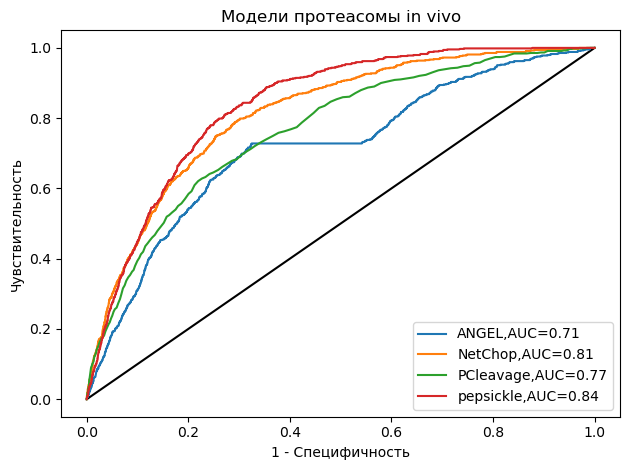

In [38]:
angel_fpr, angel_tpr, angel_thres = metrics.roc_curve(true['activity'], true['ANGEL'])
netchop_fpr, netchop_tpr, netchop_thres = metrics.roc_curve(true['activity'], true['netchop'])
pcleavage_fpr, pcleavage_tpr, pcleavage_thres = metrics.roc_curve(true['activity'], true['pcleavage'])
pepsickle_1_fpr, pepsickle_1_tpr, pepsickle_1_thres = metrics.roc_curve(true['activity'], true['pepsickle'])

angel_coords = pd.DataFrame({"fpr":angel_fpr,"tpr":angel_tpr,"thresholds":angel_thres})
netchop_coords = pd.DataFrame({"fpr":netchop_fpr,"tpr":netchop_tpr,"thresholds":netchop_thres})
pcleavage_coords = pd.DataFrame({"fpr":pcleavage_fpr,"tpr":pcleavage_tpr,"thresholds":pcleavage_thres})
pepsickle_1_coords = pd.DataFrame({"fpr":pepsickle_1_fpr,"tpr":pepsickle_1_tpr,"thresholds":pepsickle_1_thres})


plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color="black")
plt.plot(angel_fpr, angel_tpr, label=f"ANGEL,AUC={round(metrics.roc_auc_score(true['activity'], true['ANGEL']), 2)}")
plt.plot(netchop_fpr, netchop_tpr,
         label=f"NetChop,AUC={round(metrics.roc_auc_score(true['activity'], true['netchop']), 2)}")
plt.plot(pcleavage_fpr, pcleavage_tpr,
         label=f"PCleavage,AUC={round(metrics.roc_auc_score(true['activity'], true['pcleavage']), 2)}")
plt.plot(pepsickle_1_fpr, pepsickle_1_tpr,
         label=f"pepsickle,AUC={round(metrics.roc_auc_score(true['activity'], true['pepsickle']), 2)}")
plt.xlabel("1 - Специфичность")
plt.ylabel("Чувствительность")
plt.title("Модели протеасомы in vivo")
plt.legend()
plt.tight_layout()
plt.savefig("Proteasome/in_vivo/results/validation/plots/roc.png")

In [39]:
angel_coords["Gmean"] = np.sqrt(angel_coords["tpr"] * (1 - angel_coords["fpr"]))
angel_coords["J"] = angel_coords["tpr"] - angel_coords["fpr"]
optim_threshold_angel = angel_coords.loc[np.argmax(angel_coords["J"]), "thresholds"]

netchop_coords["Gmean"] = np.sqrt(netchop_coords["tpr"] * (1 - netchop_coords["fpr"]))
netchop_coords["J"] = netchop_coords["tpr"] - netchop_coords["fpr"]
optim_threshold_netchop = netchop_coords.loc[np.argmax(netchop_coords["J"]), "thresholds"]

pcleavage_coords["Gmean"] = np.sqrt(pcleavage_coords["tpr"] * (1 - pcleavage_coords["fpr"]))
pcleavage_coords["J"] = pcleavage_coords["tpr"] - pcleavage_coords["fpr"]
optim_threshold_pcleavage = pcleavage_coords.loc[np.argmax(pcleavage_coords["J"]), "thresholds"]

pepsickle_1_coords["Gmean"] = np.sqrt(pepsickle_1_coords["tpr"] * (1 - pepsickle_1_coords["fpr"]))
pepsickle_1_coords["J"] = pepsickle_1_coords["tpr"] - pepsickle_1_coords["fpr"]
optim_threshold_pepsickle = pepsickle_1_coords.loc[np.argmax(pepsickle_1_coords["J"]), "thresholds"]

In [45]:
optim_threshold_pcleavage

-0.04

In [52]:
tbl1 = true.copy(deep = True)
tbl1["pred"] = np.where(tbl1["ANGEL"] < optim_threshold_angel, 0, 1)
model_summary = pd.DataFrame(columns=["Sens","Spec","PPV","NPV","Precision",'Accuracy',"Balanced Accuracy", "F1", "MCC"])
tn, fp, fn, tp = metrics.confusion_matrix(tbl1["activity"],tbl1["pred"]).ravel()
model_summary.loc["ANGEL","Sens"] = tp / (tp + fn)
model_summary.loc["ANGEL","Spec"] = tn / (tn + fp)
model_summary.loc["ANGEL","PPV"] = tp / (tp + fp)
model_summary.loc["ANGEL","NPV"] = tn / (tn + fn)
model_summary.loc["ANGEL","Precision"] = metrics.precision_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["ANGEL","Accuracy"] = metrics.accuracy_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["ANGEL","Balanced Accuracy"] = metrics.balanced_accuracy_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["ANGEL","F1"] = metrics.f1_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["ANGEL","MCC"] = metrics.matthews_corrcoef(tbl1["activity"],tbl1["pred"])

tbl1["pred"] = np.where(tbl1["pepsickle"] < optim_threshold_pepsickle, 0, 1)
tn, fp, fn, tp = metrics.confusion_matrix(tbl1["activity"],tbl1["pred"]).ravel()
model_summary.loc["pepsickle","Sens"] = tp / (tp + fn)
model_summary.loc["pepsickle","Spec"] = tn / (tn + fp)
model_summary.loc["pepsickle","PPV"] = tp / (tp + fp)
model_summary.loc["pepsickle","NPV"] = tn / (tn + fn)
model_summary.loc["pepsickle","Precision"] = metrics.precision_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["pepsickle","Accuracy"] = metrics.accuracy_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["pepsickle","Balanced Accuracy"] = metrics.balanced_accuracy_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["pepsickle","F1"] = metrics.f1_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["pepsickle","MCC"] = metrics.matthews_corrcoef(tbl1["activity"],tbl1["pred"])

tbl1["pred"] = np.where(tbl1["pcleavage"] < optim_threshold_pcleavage, 0, 1)
tn, fp, fn, tp = metrics.confusion_matrix(tbl1["activity"],tbl1["pred"]).ravel()
model_summary.loc["Pcleavage","Sens"] = tp / (tp + fn)
model_summary.loc["Pcleavage","Spec"] = tn / (tn + fp)
model_summary.loc["Pcleavage","PPV"] = tp / (tp + fp)
model_summary.loc["Pcleavage","NPV"] = tn / (tn + fn)
model_summary.loc["Pcleavage","Precision"] = metrics.precision_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["Pcleavage","Accuracy"] = metrics.accuracy_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["Pcleavage","Balanced Accuracy"] = metrics.balanced_accuracy_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["Pcleavage","F1"] = metrics.f1_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["Pcleavage","MCC"] = metrics.matthews_corrcoef(tbl1["activity"],tbl1["pred"])

tbl1["pred"] = np.where(tbl1["netchop"] < optim_threshold_pepsickle, 0, 1)
tn, fp, fn, tp = metrics.confusion_matrix(tbl1["activity"],tbl1["pred"]).ravel()
model_summary.loc["NetChop","Sens"] = tp / (tp + fn)
model_summary.loc["NetChop","Spec"] = tn / (tn + fp)
model_summary.loc["NetChop","PPV"] = tp / (tp + fp)
model_summary.loc["NetChop","NPV"] = tn / (tn + fn)
model_summary.loc["NetChop","Precision"] = metrics.precision_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["NetChop","Accuracy"] = metrics.accuracy_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["NetChop","Balanced Accuracy"] = metrics.balanced_accuracy_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["NetChop","F1"] = metrics.f1_score(tbl1["activity"],tbl1["pred"])
model_summary.loc["NetChop","MCC"] = metrics.matthews_corrcoef(tbl1["activity"],tbl1["pred"])

model_summary.head()

,Sens,Spec,PPV,NPV,Precision,Accuracy,Balanced Accuracy,F1,MCC
ANGEL,0.727931,0.675212,0.074112,0.985813,0.074112,0.67703,0.701571,0.134528,0.15543
pepsickle,0.798842,0.739921,0.098854,0.990384,0.098854,0.741953,0.769382,0.175936,0.219267
Pcleavage,0.620839,0.780649,0.091804,0.982949,0.091804,0.775138,0.700744,0.159955,0.173241
NetChop,0.826339,0.658776,0.079604,0.990673,0.079604,0.664554,0.742557,0.145219,0.184642


In [47]:
tbl1["pred"] = np.where(tbl1["ANGEL"] < optim_threshold_angel, 0, 1)
metrics.confusion_matrix(tbl1["activity"],tbl1["pred"])

array([[13064,  6284],
       [  188,   503]])

In [48]:
tbl1["pred"] = np.where(tbl1["pcleavage"] < optim_threshold_pcleavage, 0, 1)
metrics.confusion_matrix(tbl1["activity"],tbl1["pred"])

array([[15104,  4244],
       [  262,   429]])

In [50]:
tbl1["pred"] = np.where(tbl1["pepsickle"] < optim_threshold_pepsickle, 0, 1)
metrics.confusion_matrix(tbl1["activity"],tbl1["pred"])

array([[14316,  5032],
       [  139,   552]])

In [54]:
tbl1["pred"] = np.where(tbl1["netchop"] < optim_threshold_netchop, 0, 1)
metrics.confusion_matrix(tbl1["activity"],tbl1["pred"])

array([[13599,  5749],
       [  142,   549]])

In [55]:
metrics.confusion_matrix(tbl1["activity"],tbl1["pred"]).ravel()

array([13599,  5749,   142,   549])